In [2]:
from sklearn.manifold import TSNE
import torch
from time import time
import pickle
import torch
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import os
import torchvision.transforms as T
from collections import Counter

import torchvision.datasets as datasets
import random
import torch.utils.data as Data
import gc
from sklearn.cluster import KMeans
import numpy as np
from imagenet10Folder import imagenet10Folder 

# def sim_layer(unitsA, unitsB):
#     u = list(set(unitsA) | set(unitsB))
#     i = list(set(unitsA) & set(unitsB))
#     return len(i), len(u)

# def similarity(pathsA, pathsB):
#     sim = 0.0
#     sims = []
#     lis = 0
#     lus = 0
#     for layer in range(len(pathsA)):
#         li, lu = sim_layer(pathsA[layer], pathsB[layer])
#         lis += li
#         lus += lu
#         sims.append(li/lu)
# #     sim = sim/len(pathsA)
# #     return sim, sims
#     return lis/lus, sims
def sim_layer(unitsA, unitsB):
    u = list(set(unitsA) | set(unitsB))
    i = list(set(unitsA) & set(unitsB))
    return len(i)/len(u)

def similarity(pathsA, pathsB):
    sim = 0
    sims = []
    for layer in range(len(pathsA)):
        sim += sim_layer(pathsA[layer], pathsB[layer])
        sims.append(sim_layer(pathsA[layer], pathsB[layer]))
    sim = sim/len(pathsA)
    return sim, sims

def get_random(samples, num_picked, badboys=[]):
    picked = []
    indexs = []
    if len(samples) - len(badboys) < num_picked:
        print("not enough samples")
        return False
    while len(picked) < num_picked:
        index = random.randint(0, len(samples)-1)
        if index not in indexs and index not in badboys:
            indexs.append(index)
            picked.append(samples[index])
    return picked

def get_similarity(samples1, samples2):
    s_all = 0.0
    sims_avg = np.array([0.0 for _ in range(len(paths[0]))])
    for s1 in samples1:
        p1 = paths[s1]
        for s2 in samples2:
            p2 = paths[s2]
            s, sims = similarity(p1, p2)
#             print(sims)
            s_all += s
            sims_avg = sims_avg + np.array(sims)       
    s_avg = s_all / (len(samples1) * len(samples2))
    return s_avg, sims_avg/(len(samples1) * len(samples2))

def get_similarity_samples_cluster(samples1, path2):
    s_all = 0.0
    num = 0.0
    sims_avg = np.array([0.0 for _ in range(len(paths[0]))])
    for s1 in samples1:
        p1 = paths[s1]
        p2 = path2
#         print("p1", [len(p) for p in p1])
#         print("p2", [len(p) for p in p2])
#         print("p1", p1)
#         print("p2", p2)
        s, sims = similarity(p1, p2)
#         print(s, sims)
        s_all += s
        num += 1
        sims_avg = sims_avg + np.array(sims)       
    s_avg = s_all / num
    return s_avg, sims_avg/num

data_path = "LRP_path/imagenet_vgg16_bn_lrp_path_threshold0.7_train.pkl"
with open(data_path, 'rb') as fr:
    paths = pickle.load(fr)
    
picked_samples_classes = [[] for _ in range(10)]
num_cluster = 4
for cla in range(10):
    for clu in range(num_cluster):
        l = "{}_{}".format(cla, clu)
        picked_samples_fname = "cluster_paths/vgg16_bn_binary_cluster/num_cluster{}_class{}_cluster{}_picked_samples.pkl".format(num_cluster, cla, clu)
        with open(picked_samples_fname, "rb") as f:
            unpickler = pickle.Unpickler(f)
            picked_samples = unpickler.load()
        picked_samples_classes[cla].append(picked_samples)

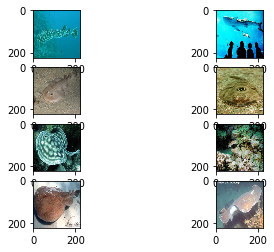

In [3]:
import torchvision.transforms as transforms

picked_num = 2
sims_avg = np.array([0.0 for _ in range(len(paths[0]))])
cla = 5
cluster0 = get_random(picked_samples_classes[cla][0], picked_num, [])
cluster1 = get_random(picked_samples_classes[cla][1], picked_num, [])
cluster2 = get_random(picked_samples_classes[cla][2], picked_num, [])
cluster3 = get_random(picked_samples_classes[cla][3], picked_num, [])

f, axarr = plt.subplots(4, picked_num)

transform_test = T.Compose([
    T.ToTensor(),
#         transforms.Normalize((0.1307,), (0.3081,)),
])
train_dir = "/mnt/dataset/Image__ILSVRC2012/ILSVRC2012_img_train/train/"
val_dir = "/mnt/mfs/litl/ICSE_CriticalPath/data/ILSVRC2012_img_val/"
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
dataset = imagenet10Folder(
    train_dir,
    transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
#         normalize,
    ]))

clusters = [cluster0, cluster1, cluster2, cluster3]
toPIL = T.Compose([T.ToPILImage()])
for i in range(len(clusters)):
    clus = clusters[i]
    for j, img in enumerate(clus):
        x =  toPIL(dataset[img][0])
        x.save('photo5/'+str(i)+'_'+str(j)+'.jpg')
        pic = dataset[img][0]
#         print(pic)

axarr[i,j].imshow(toPIL(pic))

In [11]:
from vgg import vgg16_bn
ori_model = vgg16_bn(num_classes=10)
model_path = "./trained_models/vgg16_bn_lr0.0001_49_imagenet_train_layer-1_withDataAugment.pkl"
checkpoint = torch.load(model_path)
ori_model.load_state_dict(checkpoint) 
ori_model= ori_model.cuda(0)

In [12]:
# for i in range(len(picked_samples_classes)):
#     for j in range(len(picked_samples_classes[i])):
#         print(f"class{i} cluster{j}: {len(picked_samples_classes[i][j])}")

picked_num = 10
sims_avg = np.array([0.0 for _ in range(len(paths[0]))])
s_all = 0
s_array = []
num = 0
cla1 = 7
cla2 = 8
clu1 = 2
clu2 = 2
samples1_1 = get_random(picked_samples_classes[cla][clu], picked_num, [])
samples2_1 = get_random(picked_samples_classes[cla2][clu], picked_num, [])
samples1_2 = get_random(picked_samples_classes[cla][clu2], picked_num, [])
samples2_2 = get_random(picked_samples_classes[cla2][clu2], picked_num, [])
s, sims = get_similarity(samples1_1, samples1_2)
print(s, sims)
s, sims = get_similarity(samples1_1, samples2_1)
print(s, sims)
s, sims = get_similarity(samples1_1, samples2_2)
print(s, sims)
s, sims = get_similarity(samples2_1, samples2_2)
print(s, sims)


class0 cluster0: 264
class0 cluster1: 236
class0 cluster2: 499
class0 cluster3: 270
class1 cluster0: 362
class1 cluster1: 269
class1 cluster2: 294
class1 cluster3: 350
class2 cluster0: 188
class2 cluster1: 402
class2 cluster2: 208
class2 cluster3: 326
class3 cluster0: 191
class3 cluster1: 235
class3 cluster2: 198
class3 cluster3: 322
class4 cluster0: 197
class4 cluster1: 370
class4 cluster2: 340
class4 cluster3: 147
class5 cluster0: 185
class5 cluster1: 266
class5 cluster2: 267
class5 cluster3: 333
class6 cluster0: 194
class6 cluster1: 269
class6 cluster2: 220
class6 cluster3: 208
class7 cluster0: 254
class7 cluster1: 384
class7 cluster2: 208
class7 cluster3: 269
class8 cluster0: 284
class8 cluster1: 270
class8 cluster2: 163
class8 cluster3: 326
class9 cluster0: 301
class9 cluster1: 301
class9 cluster2: 249
class9 cluster3: 439
0.41622280200906014 [0.3483461  0.40685859 0.41671002 0.45512058 0.40572692 0.41651942
 0.46141978 0.3905492  0.39546778 0.44163149 0.43104697 0.45533769
 0.386

tensor(1.7563, device='cuda:0', grad_fn=<MaxBackward0>)


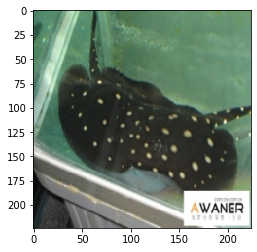

tensor(0.3906, device='cuda:0', grad_fn=<MaxBackward0>)


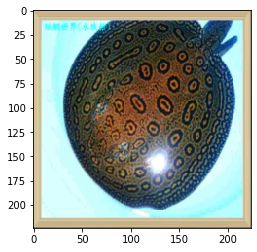

tensor(-0.0024, device='cuda:0', grad_fn=<MaxBackward0>)


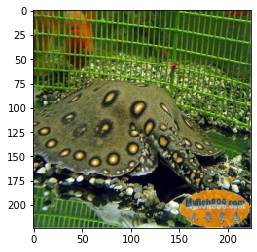

tensor(0.4100, device='cuda:0', grad_fn=<MaxBackward0>)


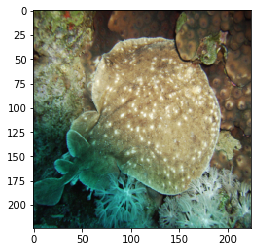

tensor(2.3103, device='cuda:0', grad_fn=<MaxBackward0>)


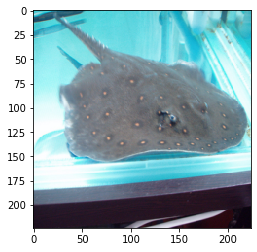

tensor(1.1618, device='cuda:0', grad_fn=<MaxBackward0>)


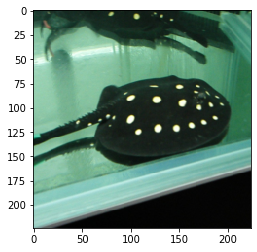

tensor(0.5670, device='cuda:0', grad_fn=<MaxBackward0>)


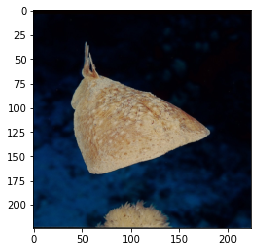

tensor(1.4659, device='cuda:0', grad_fn=<MaxBackward0>)


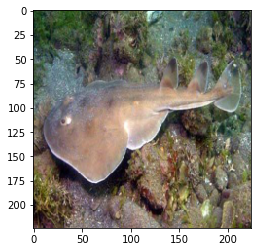

tensor(1.6569, device='cuda:0', grad_fn=<MaxBackward0>)


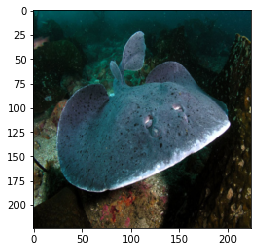

tensor(1.5148, device='cuda:0', grad_fn=<MaxBackward0>)


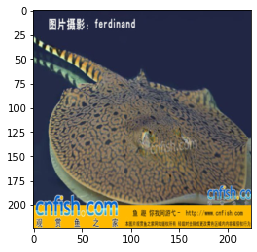

In [16]:
for i in samples1_1:
#     print(dataset[i][0])
    toPIL = T.Compose([T.ToPILImage()])
    plt.imshow(toPIL(dataset[i][0]))
    image = dataset[i][0].unsqueeze(0).cuda()
    logit, val_output = ori_model(image).squeeze().max(0)
    print(logit)
    plt.show()

tensor(1.2142, device='cuda:0', grad_fn=<MaxBackward0>)


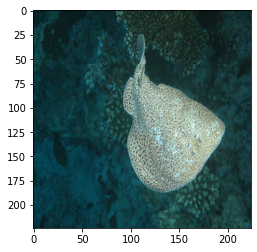

tensor(1.7397, device='cuda:0', grad_fn=<MaxBackward0>)


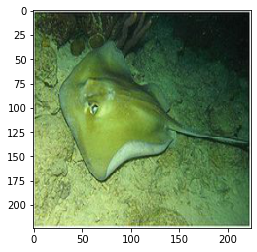

tensor(2.3997, device='cuda:0', grad_fn=<MaxBackward0>)


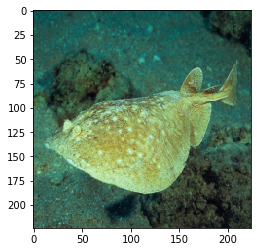

tensor(1.1837, device='cuda:0', grad_fn=<MaxBackward0>)


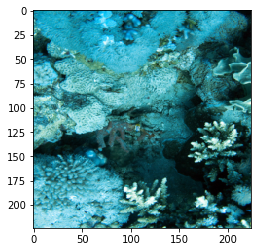

tensor(0.3820, device='cuda:0', grad_fn=<MaxBackward0>)


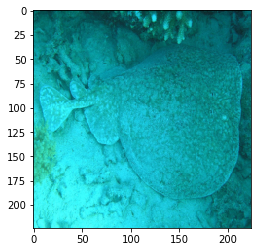

tensor(1.8850, device='cuda:0', grad_fn=<MaxBackward0>)


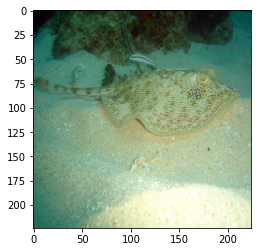

tensor(0.8044, device='cuda:0', grad_fn=<MaxBackward0>)


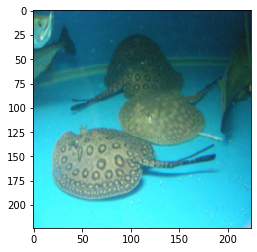

tensor(3.5316, device='cuda:0', grad_fn=<MaxBackward0>)


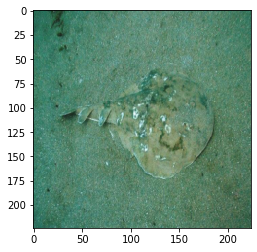

tensor(1.1398, device='cuda:0', grad_fn=<MaxBackward0>)


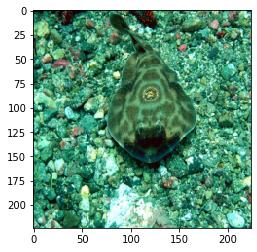

tensor(2.0581, device='cuda:0', grad_fn=<MaxBackward0>)


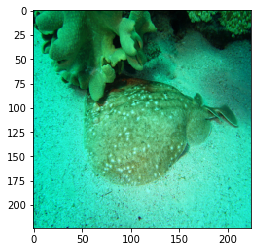

In [13]:
for i in samples1_2:
#     print(dataset[i][0])
    toPIL = T.Compose([T.ToPILImage()])
    plt.imshow(toPIL(dataset[i][0]))
    image = dataset[i][0].unsqueeze(0).cuda()
    logit, val_output = ori_model(image).squeeze().max(0)
    print(logit)
    plt.show()

tensor(0.5659, device='cuda:0', grad_fn=<MaxBackward0>)


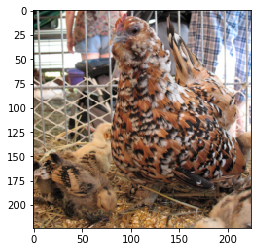

tensor(0.8144, device='cuda:0', grad_fn=<MaxBackward0>)


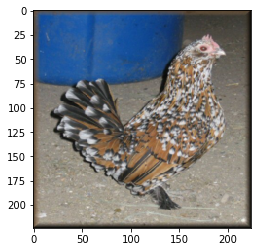

tensor(1.0349, device='cuda:0', grad_fn=<MaxBackward0>)


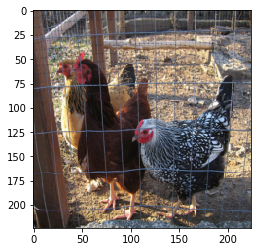

tensor(2.2422, device='cuda:0', grad_fn=<MaxBackward0>)


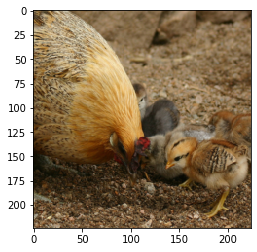

tensor(3.1437, device='cuda:0', grad_fn=<MaxBackward0>)


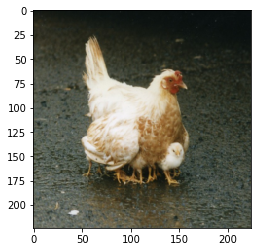

tensor(1.0380, device='cuda:0', grad_fn=<MaxBackward0>)


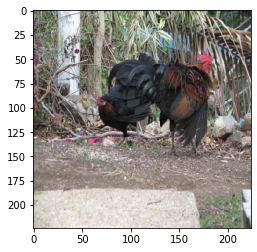

tensor(2.3653, device='cuda:0', grad_fn=<MaxBackward0>)


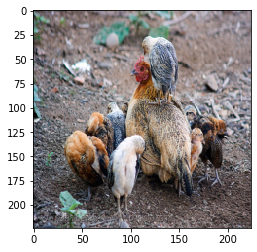

tensor(1.4579, device='cuda:0', grad_fn=<MaxBackward0>)


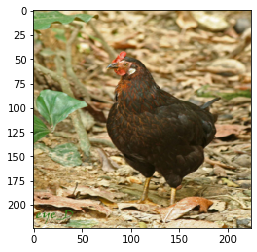

tensor(2.4399, device='cuda:0', grad_fn=<MaxBackward0>)


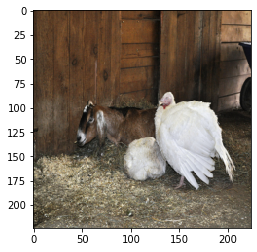

tensor(1.7263, device='cuda:0', grad_fn=<MaxBackward0>)


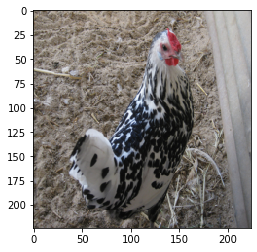

In [14]:
for i in samples2_1:
#     print(dataset[i][0])
    toPIL = T.Compose([T.ToPILImage()])
    plt.imshow(toPIL(dataset[i][0]))
    image = dataset[i][0].unsqueeze(0).cuda()
    logit, val_output = ori_model(image).squeeze().max(0)
    print(logit)
    plt.show()

tensor(3.7291, device='cuda:0', grad_fn=<MaxBackward0>)


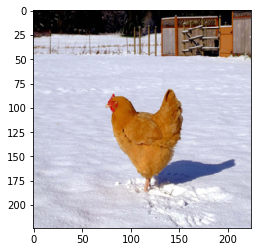

tensor(0.9348, device='cuda:0', grad_fn=<MaxBackward0>)


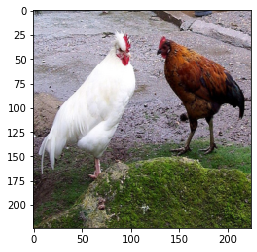

tensor(1.4559, device='cuda:0', grad_fn=<MaxBackward0>)


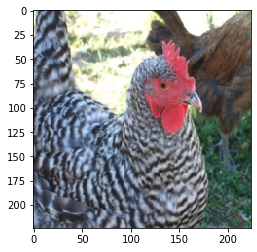

tensor(1.5018, device='cuda:0', grad_fn=<MaxBackward0>)


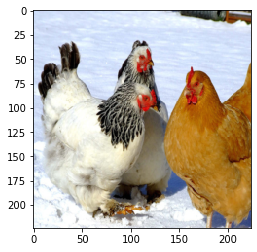

tensor(3.2780, device='cuda:0', grad_fn=<MaxBackward0>)


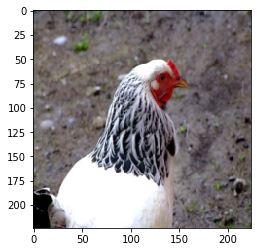

tensor(1.9487, device='cuda:0', grad_fn=<MaxBackward0>)


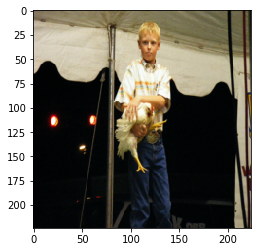

tensor(0.6439, device='cuda:0', grad_fn=<MaxBackward0>)


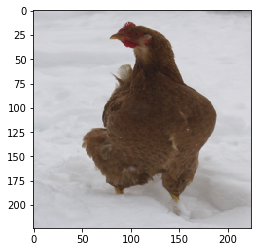

tensor(1.4811, device='cuda:0', grad_fn=<MaxBackward0>)


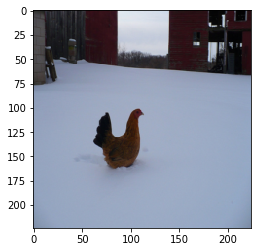

tensor(0.5959, device='cuda:0', grad_fn=<MaxBackward0>)


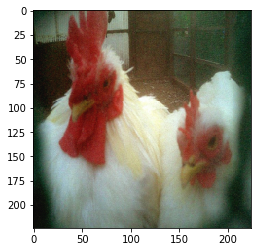

tensor(2.1372, device='cuda:0', grad_fn=<MaxBackward0>)


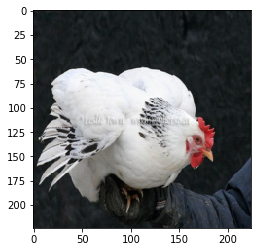

In [15]:
for i in samples2_2:
#     print(dataset[i][0])
    toPIL = T.Compose([T.ToPILImage()])
    plt.imshow(toPIL(dataset[i][0]))
    image = dataset[i][0].unsqueeze(0).cuda()
    logit, val_output = ori_model(image).squeeze().max(0)
    print(logit)
    plt.show()

In [36]:
path_fname = "cluster_paths/convmnist_binary_cluster/num_cluster{}_threshold{}_class{}_cluster{}_paths.pkl".format(num_cluster, 0.4, cla, clu)
with open(path_fname, "rb") as f:
    unpickler = pickle.Unpickler(f)
    path1_1 = unpickler.load()[0]
path_fname = "cluster_paths/convmnist_binary_cluster/num_cluster{}_threshold{}_class{}_cluster{}_paths.pkl".format(num_cluster, 0.4, cla2, clu)
with open(path_fname, "rb") as f:
    unpickler = pickle.Unpickler(f)
    path2_1 = unpickler.load()[0]
path_fname = "cluster_paths/convmnist_binary_cluster/num_cluster{}_threshold{}_class{}_cluster{}_paths.pkl".format(num_cluster, 0.4, cla, clu2)
with open(path_fname, "rb") as f:
    unpickler = pickle.Unpickler(f)
    path1_2 = unpickler.load()[0]
path_fname = "cluster_paths/convmnist_binary_cluster/num_cluster{}_threshold{}_class{}_cluster{}_paths.pkl".format(num_cluster, 0.4, cla2, clu)
with open(path_fname, "rb") as f:
    unpickler = pickle.Unpickler(f)
    path2_2= unpickler.load()[0]
s, sims = get_similarity_samples_cluster(samples1_1, path1_1)
print(s, sims)
ss, sims = get_similarity_samples_cluster(samples2_1, path2_1)
print(s, sims)
s, sims = get_similarity_samples_cluster(samples1_2, path1_2)
print(s, sims)
s, sims = get_similarity_samples_cluster(samples2_2, path2_2)
print(s, sims)

p1 [[18, 47, 28, 59, 4, 45, 41, 27, 44, 9, 30], [3, 61, 17, 41, 12, 51], [50, 81, 74, 107, 41, 97, 7, 108, 75, 1]]
p2 [[47, 18, 28, 59, 41, 4, 44, 9, 27, 45, 55], [17, 3, 41, 61, 12, 51, 31], [81, 50, 41, 107, 108, 97, 40, 1, 28]]
p1 [[18, 47, 28, 59, 41, 4, 44, 27, 55, 45, 9, 30], [17, 3, 12, 42, 51, 41], [75, 81, 40, 28, 108, 112, 41, 97]]
p2 [[47, 18, 28, 59, 41, 4, 44, 9, 27, 45, 55], [17, 3, 41, 61, 12, 51, 31], [81, 50, 41, 107, 108, 97, 40, 1, 28]]
p1 [[18, 28, 59, 47, 41, 45, 4, 44, 27, 9, 30], [17, 3, 61, 41, 12, 51], [40, 108, 112, 124, 107, 97, 41]]
p2 [[47, 18, 28, 59, 41, 4, 44, 9, 27, 45, 55], [17, 3, 41, 61, 12, 51, 31], [81, 50, 41, 107, 108, 97, 40, 1, 28]]
p1 [[47, 18, 28, 59, 4, 41, 45, 44, 55, 9], [17, 3, 12, 41, 51, 61], [50, 108, 81, 112, 107, 41, 1, 40]]
p2 [[47, 18, 28, 59, 41, 4, 44, 9, 27, 45, 55], [17, 3, 41, 61, 12, 51, 31], [81, 50, 41, 107, 108, 97, 40, 1, 28]]
p1 [[18, 47, 28, 59, 41, 4, 44, 27, 55, 9, 45], [17, 3, 41, 61, 51, 31], [50, 81, 40, 124, 107, 

In [45]:
s, sims = get_similarity_samples_cluster(samples1_1, path1_2)
print("result", s, sims)
s, sims = get_similarity_samples_cluster(samples1_1, path2_2)
print("result", s, sims)
s, sims = get_similarity_samples_cluster(samples2_1, path2_1)
print(s, sims)
s, sims = get_similarity_samples_cluster(samples1_2, path2_1)
print(s, sims)

result 0.6117254921911786 [0.81300366 0.73220899 0.28996382]
result 0.39688387635756056 [0.53869396 0.64537037 0.0065873 ]
0.805504946168001 [0.81987157 0.88898148 0.70766178]
0.4696942271503674 [0.59668616 0.80277778 0.00961874]


In [59]:
fname = "./cluster_paths/convmnist_binary_cluster/samples_class_mnist.pkl"
with open(fname, "rb") as f:
    unpickler = pickle.Unpickler(f)
    samples_class = unpickler.load()
fname = "./cluster_paths/convmnist_binary_cluster/right_samples_class_mnist.pkl"
with open(fname, "rb") as f:
    unpickler = pickle.Unpickler(f)
    right_samples_class = unpickler.load()
wrong_samples_class = []
for i in range(10):
    wrong_samples_class.append([j for j in samples_class[i] if j not in right_samples_class[i]])


[494, 902, 6848, 36446, 53216]


In [60]:
wrong_class = 1
print(wrong_samples_class[wrong_class])
paths_wrong_class = []
for clu in range(num_cluster):
    path_fname = "cluster_paths/convmnist_binary_cluster/num_cluster{}_threshold{}_class{}_cluster{}_paths.pkl".format(num_cluster, 0.4, wrong_class, clu)
    with open(path_fname, "rb") as f:
        unpickler = pickle.Unpickler(f)
        paths_wrong_class.append(unpickler.load()[0])

s_all = []
for clu in range(num_cluster):
    s, sims = get_similarity_samples_cluster(wrong_samples_class[wrong_class], paths_wrong_class[clu])   
    print(s, sims)
    s_all.append(s)
    
print(max(s_all))

0.4939158765550692 [0.57763494 0.5546131  0.34949959]
0.6281699783489645 [0.70277163 0.78452381 0.39721449]
0.3445180045702491 [0.40266728 0.38154762 0.24933911]
0.5307115316886989 [0.65596513 0.55982143 0.37634804]
0.5653894252820336 [0.62813113 0.65714286 0.41089429]
0.4484161470418874 [0.51506315 0.5546131  0.2755722 ]
0.5833067735641265 [0.66317402 0.6672619  0.4194844 ]
0.6281699783489645


In [62]:
picked_num = 10
samples_correct = get_random(right_samples_class[wrong_class], picked_num, [])
for clu in range(num_cluster):
    s, sims = get_similarity_samples_cluster(samples_correct, paths_wrong_class[clu])   
    print(s, sims)
    s_all.append(s)
    
print(max(s_all))

0.5590604221486574 [0.59392496 0.60416667 0.47908964]
0.6633770701262961 [0.70428571 0.70142857 0.58441692]
0.3443283044211837 [0.41555801 0.40833333 0.20909357]
0.6223697472691281 [0.69225576 0.64785714 0.52699634]
0.5827527723967353 [0.64810777 0.59714286 0.50300769]
0.49463275873879586 [0.5255459  0.60416667 0.35418571]
0.7110603748103749 [0.75055556 0.71714286 0.66548271]
0.7110603748103749


In [113]:
import numpy as np
import sys
sys.path.append("LRP_path")

from innvestigator import InnvestigateModel
from inverter_util import Flatten
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import argparse
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as Data
from models.VGG_16 import VGG16
# from models.vgg import vgg16_bn
from dataloader_adv_test import DatasetAdv

from models.sa_models import ConvnetMnist, ConvnetCifar
import pickle
from get_a_single_path import getPath

paths_all = []
for cla in range(10):
    paths_class = []
    for clu in range(num_cluster):
        picked_samples_fname = "cluster_paths/convmnist_binary_cluster/num_cluster{}_threshold{}_class{}_cluster{}_paths.pkl".format(num_cluster, 0.4, cla, clu)
        with open(picked_samples_fname, "rb") as f:
            unpickler = pickle.Unpickler(f)
            path = unpickler.load()
            path = path[0]
            paths_class.append(path)
    paths_all.append(paths_class)

dic = {
    "convmnist_pgd": "1hc_aj908k7_Zs2L4TsaWYENG-GwtdJe2",
    "convmnist_cw": "1aRN20FXhxvWqsIQTdDSNwei_jYSx5S7a",
    "convcifar10_pgd": "1nhWO0VT131_9e5ubgzs343EhM9Ru0UvY",
    "convcifar10_cw": "1MrRngrHDuSm2fEd044mNktkZtDSM33U4",
    "vgg_pgd": "1Gm926_p5_bvhgfDdlQmmV9lUCmjsF5Ft",
    "vgg_cw": "1-X1d-qaYGpUacej9McI5DOq20dDOk9ia",
}

model_convmnist = ConvnetMnist() 
model_convmnist.load_state_dict(torch.load("./trained_models/mnist_mixup_acc_99.28_ckpt.pth")["net"])
model_convmnist.cuda()
model_convmnist.eval()
test_loader = DatasetAdv(dic["convmnist_pgd"])


                
            


Using downloaded and verified file: ./adv_data_1hc_aj908k7_Zs2L4TsaWYENG-GwtdJe2.pkl
dict_keys(['timestamp', 'attack', 'model', 'layer', 'regularization_weight', 'epsilon', 'adversaries', 'pert_acc', 'orig_acc', 'attack_success_rate', 'neuron_coverage_000', 'neuron_coverage_020', 'neuron_coverage_050', 'neuron_coverage_075', 'inception_score', 'fid_score_64', 'fid_score_2048', 'output_impartiality'])


In [114]:
for mode in ["right", "wrong"]:
    print("mode", mode)
    
    for index, datax in enumerate(test_loader):
        
        keys = datax["key"]
        x_test = datax["your_adv"]
        y_test = datax["your_label"]
        test_loader1=torch.torch.utils.data.DataLoader(
                torch.utils.data.TensorDataset(x_test, y_test),
                batch_size=x_test.shape[0], shuffle=False)
        if index >= 1:
            break
        print("seed", index)
        for step, (x, y) in enumerate(test_loader1):
            dises = []
            sims_all = []
            x = x.cuda()
            batch_size = x.shape[0]
            val_output = model_convmnist(x)
            val_pred_logit, val_pred_y = val_output.max(1)
            path_x = getPath(x, model_convmnist, 0.8)
            logits = []
            for index in range(batch_size): 
#                 print("sample", index)
                tmps = []
                label = val_pred_y[index]      
                logit = val_pred_logit[index].item()
#                 print("\tlogit", logit)

                if mode == "mix":
                    pass
                elif mode == "right":
                    if label.item() != y[index].item():
                        continue
                elif mode == "wrong":
                    if label.item() == y[index].item():
                        continue
                        
                logits.append(logit)
                intra_paths = paths_all[label]  
                max_dis = 0
                
                for i, path in enumerate(intra_paths):
#                     print("\tcluster:", i)
#                     print("\tpath_cluster", path)
                    dis, sims = similarity(path_x[index], path)
                    sims_all.append(sims)
                    if dis > max_dis:
                        max_dis = dis
                        max_sims = sims
                    
#                     print("\t", dis)
                    print("\t", sims)
                dises.append(max_dis)
                sims_all.append(max_sims)
#                 print("\t", dises[-1])
        print(np.mean(dises))
        print(np.mean(logits))
        print(sims_all)

mode right
seed 0
	 [0.8125, 1.0, 1.0]
	 [0.7647058823529411, 1.0, 0.36363636363636365]
	 [0.9333333333333333, 1.0, 0.7777777777777778]
	 [0.631578947368421, 1.0, 0.3076923076923077]
	 [0.8666666666666667, 1.0, 0.5]
	 [0.6666666666666666, 1.0, 0.875]
	 [0.9333333333333333, 1.0, 0.5]
	 [0.3684210526315789, 0.7142857142857143, 0.23076923076923078]
	 [0.42105263157894735, 0.7142857142857143, 0.36363636363636365]
	 [0.4444444444444444, 0.7142857142857143, 0.3333333333333333]
	 [0.5555555555555556, 0.7142857142857143, 0.7]
	 [0.3157894736842105, 0.7142857142857143, 0.07142857142857142]
	 [0.5, 0.7142857142857143, 0.25]
	 [0.4444444444444444, 0.7142857142857143, 0.5]
	 [0.9333333333333333, 1.0, 0.5555555555555556]
	 [0.6666666666666666, 1.0, 0.3]
	 [0.8125, 1.0, 0.5555555555555556]
	 [0.55, 1.0, 0.15384615384615385]
	 [1.0, 1.0, 0.8571428571428571]
	 [0.5789473684210527, 1.0, 0.625]
	 [0.8125, 1.0, 0.3]
	 [1.0, 0.7142857142857143, 0.5]
	 [0.7222222222222222, 0.7142857142857143, 0.4]
	 [0.875

	 [0.4444444444444444, 0.7142857142857143, 0.7777777777777778]
	 [0.5625, 0.8571428571428571, 0.7]
	 [0.42105263157894735, 0.5555555555555556, 0.5454545454545454]
	 [0.5294117647058824, 1.0, 0.7]
	 [0.5294117647058824, 0.7142857142857143, 0.3]
	 [0.3888888888888889, 0.7142857142857143, 0.45454545454545453]
	 [0.6875, 1.0, 0.8]
	 [0.47368421052631576, 0.5555555555555556, 0.6]
	 [0.47368421052631576, 0.75, 0.5]
	 [0.8461538461538461, 0.8571428571428571, 0.5384615384615384]
	 [0.5882352941176471, 0.75, 0.6153846153846154]
	 [0.3684210526315789, 0.5555555555555556, 0.46153846153846156]
	 [0.4, 0.4444444444444444, 0.38461538461538464]
	 [0.5555555555555556, 0.5555555555555556, 0.6153846153846154]
	 [0.8125, 0.8333333333333334, 0.18181818181818182]
	 [0.8666666666666667, 1.0, 0.4]
	 [0.7647058823529411, 0.625, 0.4]
	 [0.8125, 0.8571428571428571, 0.2727272727272727]
	 [0.8125, 0.8333333333333334, 0.25]
	 [0.8666666666666667, 0.8333333333333334, 0.3]
	 [0.6666666666666666, 0.8571428571428571, 

In [115]:
for mode in ["right", "wrong"]:
    print("mode", mode)
    
    for index, datax in enumerate(test_loader):

        keys = datax["key"]
        x_test = datax["your_data"]
        y_test = datax["your_label"]
        test_loader1=torch.torch.utils.data.DataLoader(
                torch.utils.data.TensorDataset(x_test, y_test),
                batch_size=x_test.shape[0], shuffle=False)
        if index >= 1:
            break
        print("seed", index)
        for step, (x, y) in enumerate(test_loader1):
            dises = []
            sims_all = np.array([0.0 for _ in range(3)])
            x = x.cuda()
            batch_size = x.shape[0]
            val_output = model_convmnist(x)
            val_pred_logit, val_pred_y = val_output.max(1)
            path_x = getPath(x, model_convmnist, 0.8)
            logits = []
            for index in range(batch_size): 
#                 print("sample", index)
#                 print("path_sample", path_x[index])
                tmps = []
                label = val_pred_y[index]      
                logit = val_pred_logit[index].item()
                
#                 print("\tlogit", logit)
                
                if mode == "mix":
                    pass
                elif mode == "right":
                    if label.item() != y[index].item():
                        continue
                elif mode == "wrong":
                    if label.item() == y[index].item():
                        continue
                logits.append(logit)
                intra_paths = paths_all[label]  
                max_dis = 0
                
                for i, path in enumerate(intra_paths):
#                     print("\tcluster:", i)
#                     print("\tpath_cluster", path)
                    dis, sims = similarity(path_x[index], path)
                    sims_all.append(sims)
                    if dis > max_dis:
                        max_dis = dis
                        max_sims = sims
                    
#                     print("\t", dis)
                    print("\t", sims)
                dises.append(max_dis)
                sims_all.append(max_sims)
#                 print("\t", dises[-1])
            print(np.mean(dises))
            print(np.mean(logits))

mode right
seed 0
	 [0.875, 0.8333333333333334, 0.7777777777777778]
	 [0.8235294117647058, 0.8333333333333334, 0.36363636363636365]
	 [1.0, 0.8333333333333334, 0.7777777777777778]
	 [0.6842105263157895, 0.8333333333333334, 0.3076923076923077]
	 [0.8125, 0.8333333333333334, 0.6666666666666666]
	 [0.7222222222222222, 0.8333333333333334, 0.875]
	 [1.0, 0.8333333333333334, 0.5]
	 [0.42105263157894735, 0.7142857142857143, 0.14285714285714285]
	 [0.47368421052631576, 0.7142857142857143, 0.5]
	 [0.5, 0.7142857142857143, 0.23076923076923078]
	 [0.6111111111111112, 0.7142857142857143, 0.7]
	 [0.3684210526315789, 0.7142857142857143, 0.07142857142857142]
	 [0.5555555555555556, 0.7142857142857143, 0.15384615384615385]
	 [0.5, 0.7142857142857143, 0.36363636363636365]
	 [0.875, 0.8333333333333334, 0.4]
	 [0.631578947368421, 0.8333333333333334, 0.3]
	 [0.7647058823529411, 0.8333333333333334, 0.4]
	 [0.5238095238095238, 0.8333333333333334, 0.15384615384615385]
	 [0.9333333333333333, 0.8333333333333334

	 [0.5294117647058824, 0.7142857142857143, 0.7777777777777778]
	 [0.6666666666666666, 0.8571428571428571, 0.7]
	 [0.5, 0.5555555555555556, 0.5454545454545454]
	 [0.625, 1.0, 0.7]
	 [0.625, 0.7142857142857143, 0.3]
	 [0.47058823529411764, 0.7142857142857143, 0.45454545454545453]
	 [0.6875, 1.0, 0.8]
	 [0.8125, 0.8333333333333334, 0.18181818181818182]
	 [0.8666666666666667, 1.0, 0.4]
	 [0.7647058823529411, 0.625, 0.4]
	 [0.8125, 0.8571428571428571, 0.2727272727272727]
	 [0.8125, 0.8333333333333334, 0.25]
	 [0.8666666666666667, 0.8333333333333334, 0.3]
	 [0.6666666666666666, 0.8571428571428571, 0.25]
0.7923611111111111
6.926389694213867
